In [ ]:
pip install imblearn

In [60]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import metrics
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore',category=DataConversionWarning)
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import random  
import lightgbm as lgb
import gc
import sklearn.externals as extjoblib
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

import pickle 

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

pd.options.display.max_rows=999

In [2]:
df1 = pd.read_csv('2020_Competition_Training.csv',low_memory=False)
df1.shape

(69572, 826)

In [3]:
random.seed(3)

In [17]:
def data_cleaning(data1):
    drop_data=pd.read_csv('drop_columns.csv')
    dropped_columns=drop_data['names'].tolist()
    data2=data1.drop(dropped_columns,axis=1)
    data2.shape
    #pd.DataFrame(df2.dtypes).to_csv('data_type.csv')
    interval_data=pd.read_csv('Interval_Variables.csv')
    interval_columns=interval_data['names'].tolist()
    categorical_data=pd.read_csv('Categorical_Variables.csv')
    categorical_columns=categorical_data['names'].tolist()
    for i in categorical_columns:
        data2[i] = data2[i].astype('category')
        data2[i] = data2[i].cat.codes
        data2[i].fillna(data2[i].mode(),inplace=True)
    for i in interval_columns:
        data2[i] = (pd.to_numeric(data2[i]))*1.00000
        data2[i].fillna(data2[i].mean(),inplace=True)
    data3 = data2.drop(['person_id_syn','zip_cd','cnty_cd','state_cd'], 1)
    X1 = data3.drop(['transportation_issues'], 1)
    Y1 = data3[['transportation_issues']]
    Y1['transportation_issues'] = Y1['transportation_issues'].astype('category')
    Y1['transportation_issues'] = Y1['transportation_issues'].cat.codes
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1,Y1, test_size=0.20, stratify = Y1)
    #sm = SMOTE(random_state=12)
    #X1_train, y1_train = sm.fit_sample(X1_train, y1_train)
    return X1_train, X1_test, y1_train, y1_test


In [41]:
X_train, X_test, y_train, y_test = data_cleaning(df1)

print("Length of Training (X):",len(X_train))
print("Length of Training (Y):",len(y_train))
print("Length of Test (X):",len(X_test))
print("Length of Test (Y):",len(y_test))

print("Distribution of Y in Overall Data: ",df1['transportation_issues'].value_counts(normalize=True))
print("Distribution of Y in Train Data: ",y_train['transportation_issues'].value_counts(normalize=True))
print("Distribution of Y in Test Data: ",y_test['transportation_issues'].value_counts(normalize=True))

<ipython-input-17-3daa09cfea72>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1['transportation_issues'] = Y1['transportation_issues'].astype('category')
<ipython-input-17-3daa09cfea72>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1['transportation_issues'] = Y1['transportation_issues'].cat.codes


Length of Training (X): 55657
Length of Training (Y): 55657
Length of Test (X): 13915
Length of Test (Y): 13915
Distribution of Y in Overall Data:  0    0.853432
1    0.146568
Name: transportation_issues, dtype: float64
Distribution of Y in Train Data:  0    0.853424
1    0.146576
Name: transportation_issues, dtype: float64
Distribution of Y in Test Data:  0    0.853467
1    0.146533
Name: transportation_issues, dtype: float64


In [24]:
def Light_Gradient_Boost(df_dependent, df_target ):
    train_data=lgb.Dataset(df_dependent, label=df_target)
    params = {'boosting_type': 'gbdt',
         'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.02,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error',
          'extra_trees' : 'True',
          'is_unbalance' : 'True'
          }
    gridParams = {
    'learning_rate': [0.02,0.03],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1, 1.2],
    'reg_lambda' : [ 1.2, 1.4],
    }
    mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
       objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])
    # Create the grid
    grid = GridSearchCV(mdl, gridParams, verbose=2, cv=8, n_jobs=-1)
    # Run the grid
    grid.fit(df_dependent, df_target)
    # Using parameters already set above, replace in the best from the grid search
    params['colsample_bytree'] = grid.best_params_['colsample_bytree']
    params['learning_rate'] = grid.best_params_['learning_rate']
    params['num_leaves'] = grid.best_params_['num_leaves']
    params['reg_alpha'] = grid.best_params_['reg_alpha']
    params['reg_lambda'] = grid.best_params_['reg_lambda']
    params['subsample'] = grid.best_params_['subsample']
    #Train model on selected parameters and number of iterations
    lgbm = lgb.train(params,
                 train_data,
                 450,
                 #early_stopping_rounds= 40,
                 verbose_eval= 4
                 )
    return lgbm;

In [25]:
def evaluation_lgbm(model, df_dependent, df_target):
    predictions_lgbm_prob = model.predict(df_dependent)
    predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output
    my_crosstab = pd.crosstab(index=df_target['transportation_issues'], columns=predictions_lgbm_01,margins=True)   # Include row and column totals
    print(my_crosstab)
    #Plot Variable Importances
    lgb.plot_importance(model, max_num_features=15, importance_type='split')
    #Print accuracy
    acc_lgbm = accuracy_score(df_target,predictions_lgbm_01)
    print('Overall accuracy of Light GBM model:', acc_lgbm)
    #Print Area Under Curve
    plt.figure()
    false_positive_rate, recall, thresholds = roc_curve(df_target, predictions_lgbm_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.show()
    print('AUC score:', roc_auc)
    #Print Confusion Matrix
    plt.figure()
    cm = confusion_matrix(df_target, predictions_lgbm_01)
    labels = ['No Default', 'Default']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    

In [26]:
model_lgbm = Light_Gradient_Boost(X_train, y_train)

Fitting 8 folds for each of 192 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed: 30.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LightGBM] [Info] Number of positive: 8158, number of negative: 47499
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data points in the train set: 55657, number of used features: 362
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146576 -> initscore=-1.761710
[LightGBM] [Info] Start training from score -1.761710


col_0                      0      1    All
transportation_issues                     
0                      34089  13410  47499
1                       2294   5864   8158
All                    36383  19274  55657
Overall accuracy of Light GBM model: 0.7178432182834145


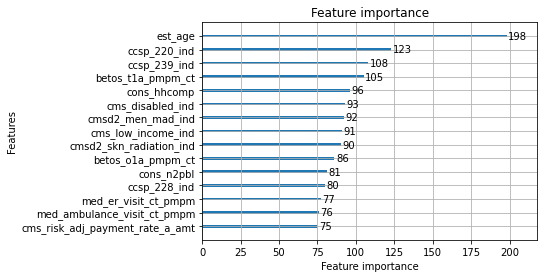

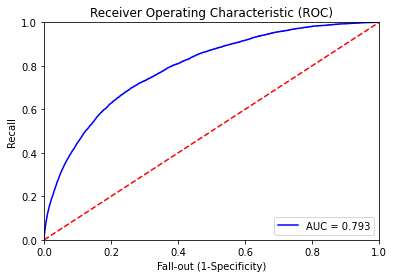

AUC score: 0.792668921931498


<Figure size 432x288 with 0 Axes>

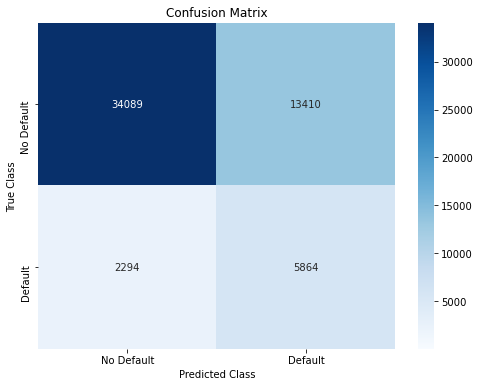

In [27]:
evaluation_lgbm(model_lgbm, X_train, y_train)

col_0                      0    1    All
transportation_issues                   
0                      11735  141  11876
1                       1847  192   2039
All                    13582  333  13915
Overall accuracy of Light GBM model: 0.8571325907294287


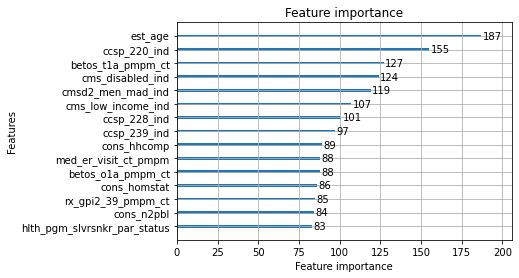

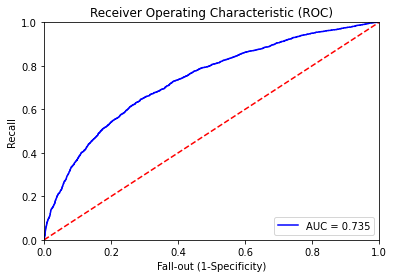

AUC score: 0.735168880128171


<Figure size 432x288 with 0 Axes>

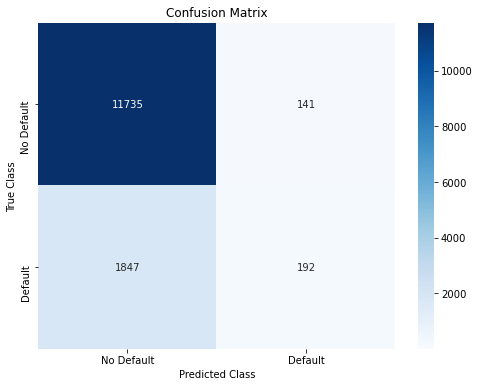

In [23]:
evaluation_lgbm(model_lgbm, X_test, y_test)

In [9]:
def Gradient_Boost(df_dependent, df_target ):
    parameters = {
        'subsample': [0.85], 
        'n_estimators': [55], 
        'min_samples_split': [0.5], 
        'min_samples_leaf': [0.1], 
        'max_features': ['auto'], 
        'max_depth': [5], 
        'loss': ['exponential'], 
        'learning_rate': [0.1], 
        'criterion': ['friedman_mse']
    }
    clf = GridSearchCV(GradientBoostingClassifier(), parameters, verbose=2, cv=5, n_jobs=-1)
    clf.fit(df_dependent, df_target.values.ravel())
    return clf

In [11]:
def evaluation_gbm(model, df_dependent, df_target):
    predictions_gbm_prob = model.decision_function(df_dependent)
    predictions_gbm_01 = model.predict(df_dependent) #Turn probability to 0-1 binary output
    my_crosstab = pd.crosstab(index=df_target['transportation_issues'], columns=predictions_gbm_01,margins=True)   # Include row and column totals
    print(my_crosstab)
    #Print accuracy
    acc_gbm = accuracy_score(df_target,predictions_gbm_01)
    print('Overall accuracy of Light GBM model:', acc_gbm)
    #Print Area Under Curve
    plt.figure()
    false_positive_rate, recall, thresholds = roc_curve(df_target, predictions_gbm_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.show()
    print('AUC score:', roc_auc)
    #Print Confusion Matrix
    plt.figure()
    cm = confusion_matrix(df_target, predictions_gbm_01)
    labels = ['No Default', 'Default']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

In [10]:
model_gbm = Gradient_Boost(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


In [12]:
y_scores_gb = model_gbm.decision_function(X_train)
fpr_gb, tpr_gb, _ = roc_curve(y_train, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.95


In [13]:
y_scores_gb = model_gbm.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.71


col_0                      0      1    All
transportation_issues                     
0                      43882   3617  47499
1                       7095  40404  47499
All                    50977  44021  94998
Overall accuracy of Light GBM model: 0.8872397313627656


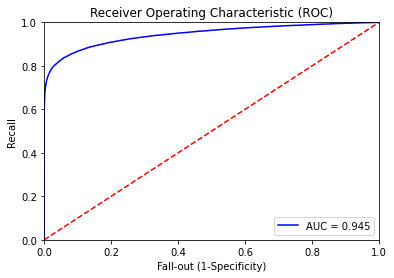

AUC score: 0.9450260645013192


<Figure size 432x288 with 0 Axes>

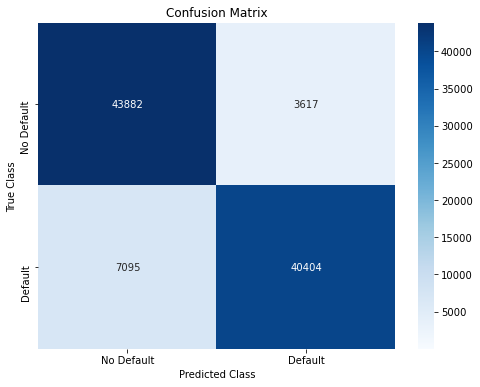

In [14]:
evaluation_gbm(model_gbm,X_train,y_train)

col_0                      0     1    All
transportation_issues                    
0                      11020   856  11876
1                       1527   512   2039
All                    12547  1368  13915
Overall accuracy of Light GBM model: 0.8287459575997126


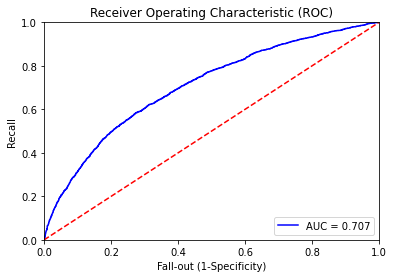

AUC score: 0.7069546173629053


<Figure size 432x288 with 0 Axes>

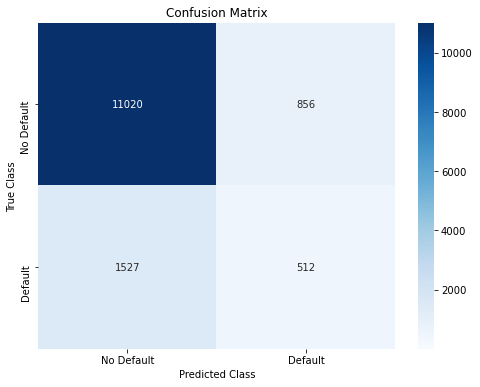

In [15]:
evaluation_gbm(model_gbm,X_test,y_test)

In [ ]:
model=RandomForestClassifier()
random_grid={'bootstrap': [True],
             'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
             'max_features': ['auto', 'sqrt'],
             'max_leaf_nodes': [None],
             'min_impurity_decrease': [0.0],
             'min_impurity_split': [None],
             'min_samples_leaf': [1, 2, 4, 5],
             'min_samples_split': [2, 5, 10],
             'min_weight_fraction_leaf': [0.0],
             'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
             'n_jobs': [1],
             'oob_score': [False],
             'random_state': [42],
             'verbose': [0],
             'warm_start': [False]}
rfc_random=model=RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=10,
                              cv=5, verbose=2,random_state=1,n_jobs=-1)

rfc_random.fit(X_train,y_train)
print(rfc_random.best_params_)
train_pred=model.predict(X_train)
cm=confusion_matrix(y_train,train_pred)
print('Confusion matrix \n:',cm)
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_train, train_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc)
accuracy=accuracy_score(y_train,train_pred)
print('Model accuracy score:', accuracy)
print('F1 score',metrics.f1_score(y_train,train_pred))

test_pred=model.predict(X_test)
cm1=confusion_matrix(y_test,test_pred)
print('Confusion Matrix:\n',cm1)
accuracy_test=accuracy_score(y_test,test_pred)
print('Model accuracy score:', accuracy_test)
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, test_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc)
print('F1 score',metrics.f1_score(y_test,test_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [45]:
def model_prediction(model1, model2, df_dependent, df_target):
    
    predictions_model1_prob = model1.predict(df_dependent)
    predictions_model1_01 = np.where(predictions_model1_prob > 0.5, 1, 0)
    print(len(predictions_model1_01))
    df_output = pd.DataFrame()
    df_output['Output_Target']=df_target['transportation_issues']
    df_output['Predicted_Target_model1'] = predictions_model1_01
    df_output['Predicted_Probability_model1'] = predictions_model1_prob    
    
    predictions_model2_prob = model2.decision_function(df_dependent)
    predictions_model2_01 = model2.predict(df_dependent) 
    print(len(predictions_model2_01))
    df_output['Predicted_Target_model2'] = predictions_model2_01
    df_output['Predicted_Probability_model2'] = predictions_model2_prob    
    
    df_output['combined_probability'] = (df_output['Predicted_Probability_model1'] + df_output['Predicted_Probability_model2'])/2
    df_output['combined_prediction(soft)'] = np.where(df_output['combined_probability'] > 0.5, 1, 0)
    df_output['combined_prediction(hard)'] = np.where((df_output['Predicted_Target_model1'] + df_output['Predicted_Target_model2'])> 0, 1, 0)
    
    return df_output

In [46]:
df_pred = model_prediction(model_lgbm ,model_gbm, X_test, y_test)

13915
13915


In [51]:
df_pred.columns

Index(['Output_Target', 'Predicted_Target_model1',
       'Predicted_Probability_model1', 'Predicted_Target_model2',
       'Predicted_Probability_model2', 'combined_probability',
       'combined_prediction(soft)', 'combined_prediction(hard)'],
      dtype='object')

In [53]:
fpr_gb, tpr_gb, _ = roc_curve(df_pred.Output_Target, df_pred.combined_probability)
roc_auc_gb = auc(fpr_gb, tpr_gb)
print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.74


In [57]:
print(classification_report(df_pred.Output_Target, df_pred['combined_prediction(soft)']))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11876
           1       0.51      0.13      0.21      2039

    accuracy                           0.85     13915
   macro avg       0.69      0.56      0.57     13915
weighted avg       0.81      0.85      0.82     13915



In [58]:
print(classification_report(df_pred.Output_Target, df_pred['combined_prediction(hard)']))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81     11876
           1       0.30      0.70      0.42      2039

    accuracy                           0.72     13915
   macro avg       0.62      0.71      0.62     13915
weighted avg       0.84      0.72      0.75     13915

